# FINISHED, JUST METTI QUALCHE SPIEGAZIONE IN Pù

## Import the useful library and the dataset

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt

df = pd.read_excel("../Datasets/Dry_Bean_Dataset.xlsx")

In [3]:
y = df['Class']
X = df.drop('Class', axis=1)

encoder = OrdinalEncoder()
y=np.array(y)
encoder.fit(y.reshape(-1,1))
y = encoder.transform(y.reshape(-1, 1))

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)


## Preprocess data by centering the variables and dividing them by their standard deviation.

In [4]:
Xtrain =  (Xtrain-Xtrain.mean() )/Xtrain.std()

## My algorithm to perform PCA

In [5]:
import numpy as np

class MyPCA:
    """
    A small class to perform PCA
    ------------
    Attributes:
    n_components: int, default is None
        number of principal components we want to project on
    eigvecs_: None
        All eigenvectors of covariance matrix decomposition, sorted w.r.t the maximum eigenvalues
    eigvals_: None
        All eigenvalues of covariance matrix decomposition, sorted w.r.t the maximum eigenvalues
    singular_values_: None
        The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space
    top_eigvecs: None
        The projection matrix
    """
    
    def __init__(self, n_components=None):
        """
        Constructor for PCA class.
        ----------
        Parameters:
        n_components : int (optional)
            The number of principal components we want to project on (default is None, meaning to project on all components).
        """
        self.n_components = n_components
        self.eigvecs_ = None
        self.eigvals_ = None
        self.singular_values_ = None
        self.top_eigvecs = None
    
    def fit_transform(self, X):
        """
        Fit the PCA model to data and transform the data.
        ----------
        Parameters:
        X : numpy array
            The data to fit the PCA model and transform, required in the form: (n x p) where n = number of observations and p = number of features
        ----------
        Returns:
        projected_data : numpy array
            The projected data.
        """
        # center the data in the feature space
        X_centered = X - np.mean(X, axis=0)

        # compute the covariance matrix
        cov_matrix = np.dot(X_centered.T, X_centered)/(X.shape[0])

        # perform eigen decomposition on the covariance matrix
        eigvals, eigvecs = np.linalg.eig(cov_matrix)

        # sort eigenvectors in decreasing order of eigenvalues
        idx = np.argsort(eigvals)[::-1]        
        eigvecs = eigvecs[:, idx]
        eigvals = eigvals[idx]
        
        self.eigvecs_ = eigvecs
        self.eigvals_ = eigvals

        self.singular_values_ = np.linalg.norm(np.dot(X, self.eigvecs_), axis = 0)

        self.top_eigvecs = self.eigvecs_

        # select the top n_components eigenvectors
        if self.n_components is not None:
            self.top_eigvecs = self.eigvecs_[:, :self.n_components]

        
        # project the original data onto the selected eigenvectors
        projected_data = np.dot(X, self.top_eigvecs)

        return projected_data

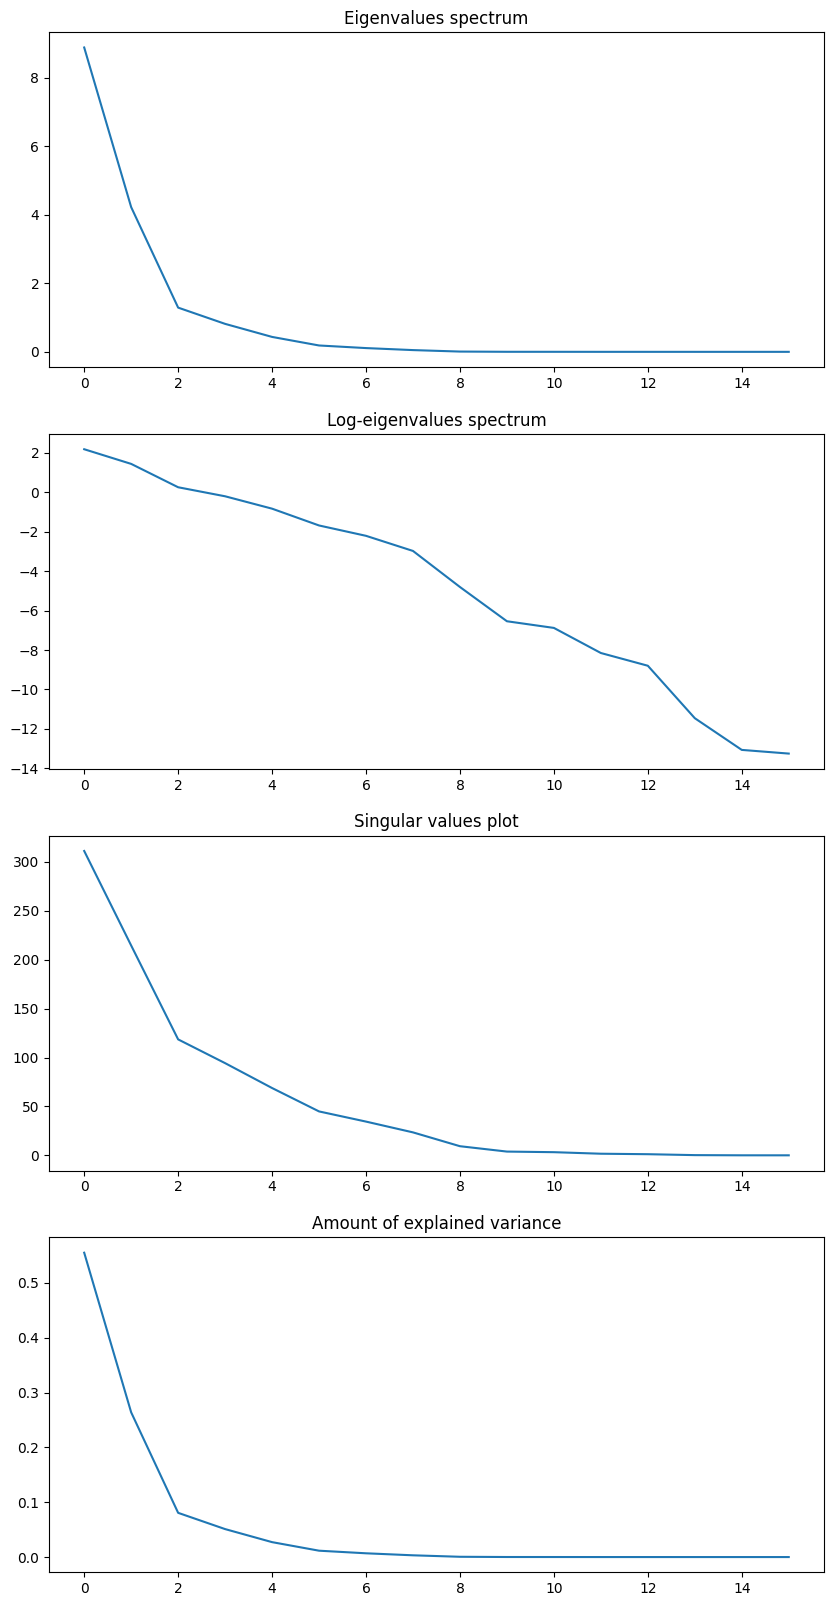

In [6]:
pca = MyPCA(n_components=2)
Y = pca.fit_transform(Xtrain)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize = (10,20))

# plot the data on the subplots
ax1.plot(pca.eigvals_)
ax1.set_title('Eigenvalues spectrum')
ax2.plot(np.log(pca.eigvals_))
ax2.set_title('Log-eigenvalues spectrum')
ax3.plot(pca.singular_values_)
ax3.set_title('Singular values plot')
ax4.plot(pca.eigvals_/pca.eigvals_.sum())
ax4.set_title('Amount of explained variance')

plt.show()


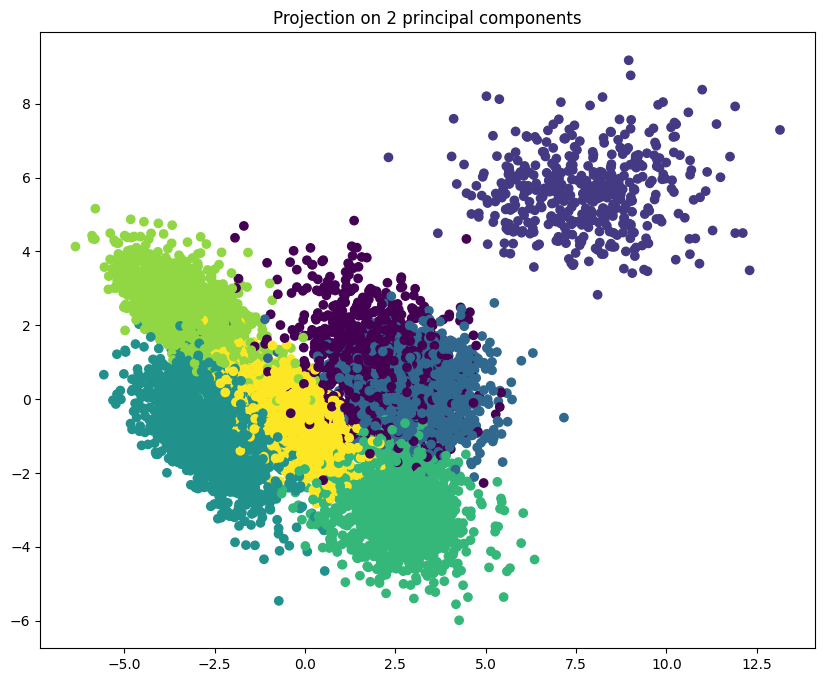

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(Y[:,0], Y[:,1], c = ytrain)
plt.title('Projection on 2 principal components')
plt.show()

In [8]:
pca = MyPCA(n_components=3)
Y = pca.fit_transform(Xtrain)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


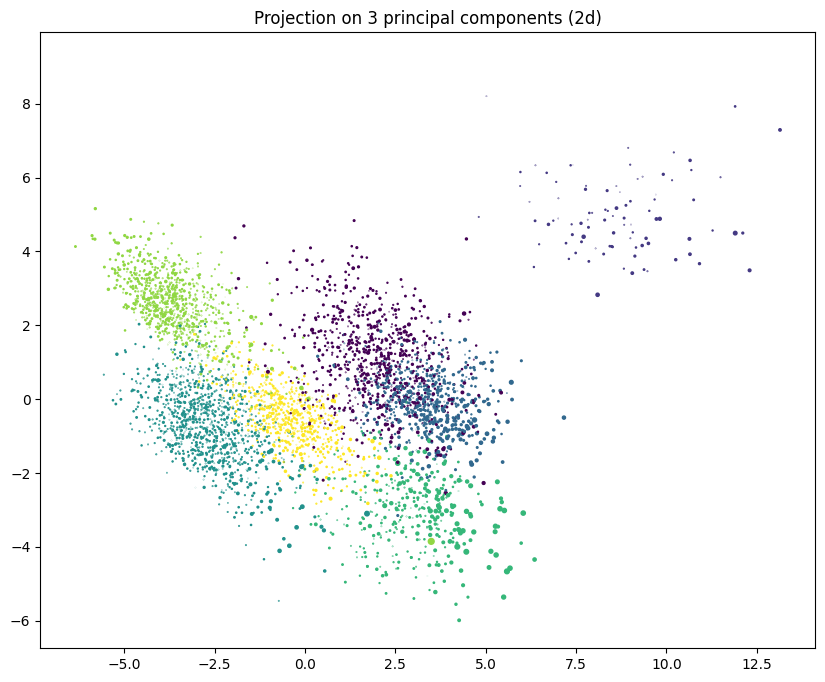

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(Y[:,0], Y[:,1], Y[:,2], c = ytrain)
plt.title('Projection on 3 principal components (2d)')
plt.show()

<Figure size 1000x800 with 0 Axes>

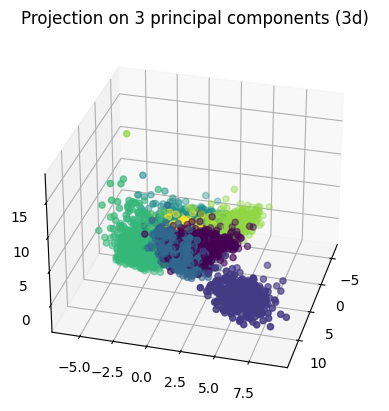

In [10]:
plt.figure(figsize=(10,8))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30,15)
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c = ytrain)
ax.set_title('Projection on 3 principal components (3d)')
plt.show()

- For an increasing number of principal components (1 to 16):
- - Apply a multinomial logistic regression to learn a model on the training set (use  ```sklearn.linear_model.LogisticRegression``` ).
- - Transform the test set with the matrix learned from the traning set. Make a prediction with the logistic model learned. 
- - Assess the quality of the predictions and comment on the results. 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Xtest = (Xtest- Xtest.mean())/Xtest.std()
accuracy = np.zeros(16)
for k in range(1,17):
    # Y is the train standardized dataset projected to k PC
    pca = MyPCA(n_components= k)
    Y = pca.fit_transform(Xtrain)


    # fit a logistic regression using the dimension-reduced dataset Xtrain_proj (nxk instead of nxp, where p = 16)
    model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
    model.fit(Y,ytrain.ravel())

    

    Xtest_proj = np.dot(Xtest, pca.top_eigvecs) # Xtest_proj is the test set transformed with the matrix learned in the training set, called proj_mtrx

    # Make a prediction with the logistic model learned.
    yhat = model.predict(Xtest_proj)

    # Assess the quality of the predictions
    acc = accuracy_score(ytest, yhat)
    accuracy[k-1] = acc
    print(f'Accuracy for {k} components: ', acc)
    

Accuracy for 1 components:  0.6276165993389644
Accuracy for 2 components:  0.8710980536173338
Accuracy for 3 components:  0.8828497980168931
Accuracy for 4 components:  0.8953360264414248
Accuracy for 5 components:  0.9232464193903782
Accuracy for 6 components:  0.922879177377892
Accuracy for 7 components:  0.9232464193903782
Accuracy for 8 components:  0.922879177377892
Accuracy for 9 components:  0.9232464193903782
Accuracy for 10 components:  0.922879177377892
Accuracy for 11 components:  0.922879177377892
Accuracy for 12 components:  0.922879177377892
Accuracy for 13 components:  0.922879177377892
Accuracy for 14 components:  0.922879177377892
Accuracy for 15 components:  0.922879177377892
Accuracy for 16 components:  0.922879177377892


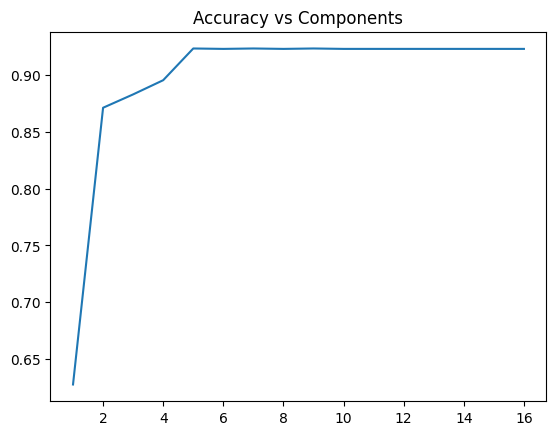

In [19]:
plt.plot(np.arange(1, 17), accuracy)
plt.title('Accuracy vs Components')
plt.show()

 si conferma che da 6 in giu, l accuracy non varia piu molto... infatti c'e un gomito a 3, ma poi un altro gomito a 6... dopo il 6, praticamente siamo stazionari

# Swiss Roll


Try to apply PCA to the Swiss Roll dataset (n = 1000) and plot the projection on the first two principal components. Choose an appropriate color scheme for visualization and comment on your results.

In [13]:
def swiss_roll(n):
    """
    Parameters:
    n: int
        Number of points to generate"""
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


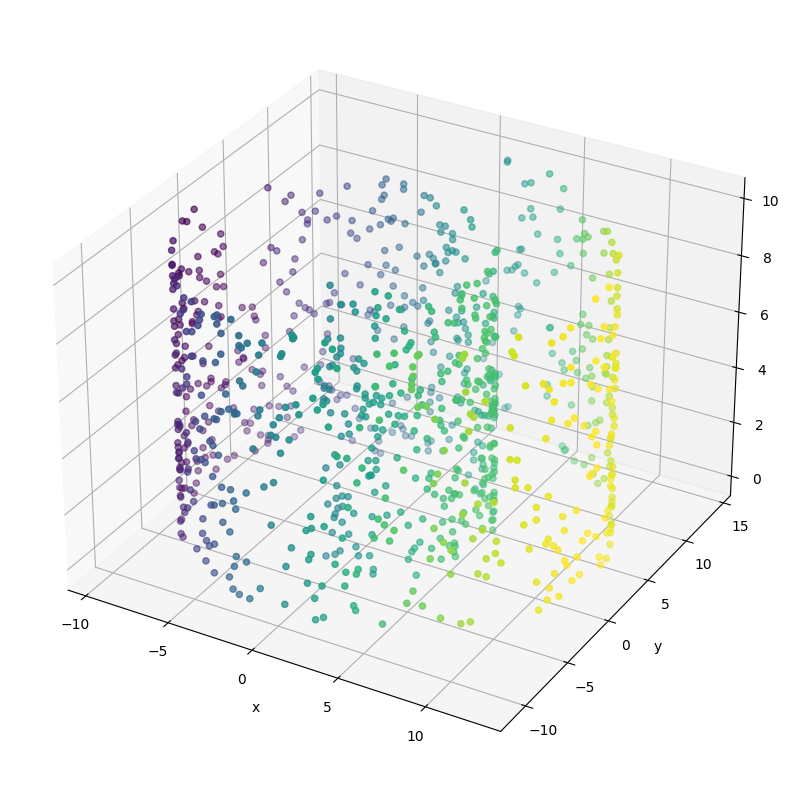

In [14]:
X = swiss_roll(1000)

plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(X[:,0], X[:,1], X[:,2], c=X[:,0])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(45, 45) #(elevation, azimuth angle)

plt.show()

In [15]:
X_std = X - X.mean(axis=0)
Y = MyPCA(n_components=2).fit_transform(X)

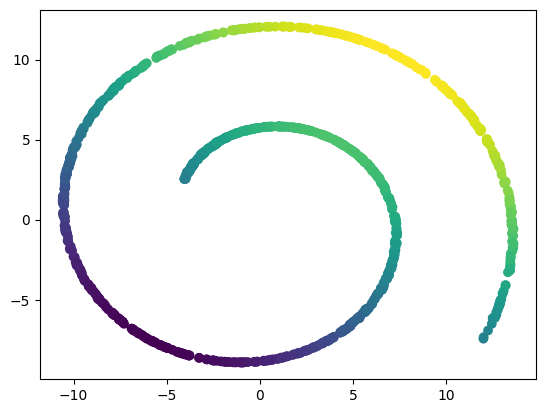

In [16]:

plt.scatter(Y[:,0], Y[:,1], c = X[:,0])